# Importing Libraries

In [1]:
import random
import csv
import hashlib
import urllib.request
import os
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import requests
import zipfile
import glob
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub

# Dataset creation
Downloading the photos from Flickr and downloading the photos as a zip. <br>
The images are being downloaded via the FlickrAPI and stored in seperate folders for each class. In order to do that the user must create a public and secret key as described on the Flickr website https://www.flickr.com/services/apps/create/apply/. Add the new values to `FLICKR_PUBLIC` and `FLICKR_SECRET`<br>
The images are stored on GitHub - due to GitHub file size limitations we were only able to store a total of 100 MB. We decided to store around 5000 images with FlickrAPI size "s". <br>
In order to run the function the variable `download_new_photos` must be set to `True`. Additional keywords/classes can be introduced as well and the amount of photos to download can be changed in the variable `TOTAL_PHOTOS`

In [2]:
# set to False to not download new photos
download_new_photos = False

# the keywords to look photos for
keywords = ['sea', 'desert', 'mountain', 'river', 'forest']

# Function to download pictures from Flickr

def download_photos():

    # install and import FlickrAPI package
    !pip install flickrapi
    from flickrapi import FlickrAPI

    # Keys for flickr API
    FLICKR_PUBLIC = '5829447acb20544b640f7c58b058614a'
    FLICKR_SECRET = '856705a9f309b147'

    # Settings (extras = different resolution of photos)
    flickr = FlickrAPI(FLICKR_PUBLIC, FLICKR_SECRET, format='parsed-json')
    extras = 'url_s'

    # how many photos per category
    TOTAL_PHOTOS = 1000
    PHOTOS_PER_PAGE = 10

    cwd = os.getcwd()
    print(f'Photos will be stored at: {cwd}')

    temp_folder = 'photos/temp'

    # create photos directory
    try:
        os.mkdir('photos')
        print('Created folder photos')
        
    except:
        print('Folder "photos" already exists')

    # download the photos per keyword
    for word in keywords:
        # get all photos of the category
        page = 1
        photos = flickr.photos.search(tags=word, text=word, page=page, per_page=PHOTOS_PER_PAGE, extras=extras, content_type=1)
        print(flickr.photos.search(tags=word, text=word, page=page, per_page=PHOTOS_PER_PAGE, extras=extras, content_type=1))

        # create subfolders
        try:
            os.mkdir('photos/'+word)
            print('Created folder ' + word)
        except:
            print(f'Folder "{word}" already exists')

        # download the photos
        j = 1 # index for filenames - won't be reset
        filename = ''
        batch = 1
        total_batch = int(TOTAL_PHOTOS/100)

        i = 0
        i_old = 0
      

        while j <= TOTAL_PHOTOS:
            
            while i == i_old:
                i = random.randint(1, PHOTOS_PER_PAGE-1)
                #print(f'index old: {i_old}, index new: {i}')
            i_old = i

            try:
                url = photos['photos']['photo'][i]['url_s']
                photo_id = photos['photos']['photo'][i]['id']
                #print(f'photo_id: {photo_id}')
            except:
                try:
                  error_photo = photos['photos']['photo'][i]
                  print(f'Error at {error_photo}')
                except:
                  print(f'Error')
                  pass

            try:
              os.mkdir(temp_folder)
            except:
              pass

            filename = 'photo_' + str(j) + '.jpg'
            directory = 'photos/' + word + "/" + filename
            directory_temp = temp_folder + "/" + filename
            urllib.request.urlretrieve(url, directory_temp)
            #print(f'Category {word}: Page {page}; Downloading {j} of {TOTAL_PHOTOS}')

            # create new csv file 
            f = open('hash_table.csv', 'a', newline='')
            f.close

            # get hash for comparison
            sha256_hash = hashlib.sha256()
            with open(directory_temp,"rb") as f:
                # Read and update hash string value in blocks of 4K
                for byte_block in iter(lambda: f.read(4096),b""):
                    sha256_hash.update(byte_block)
                hash_sha256 = sha256_hash.hexdigest()
                print(j, i, hash_sha256)

                # check if duplicate
                with open('hash_table.csv', 'r') as fp:
                    s = fp.read()

                if hash_sha256 not in s and photo_id not in s:
                    urllib.request.urlretrieve(url, directory)
                    #print(hash_sha256)
                    #print('no duplicate')
                    f = open('hash_table.csv', 'a', newline='')
                    writer = csv.writer(f)
                    row = [str(hash_sha256),photo_id]
                    writer.writerow(row)
                    f.close
                
                    if j % 100 == 0:
                        print(f'Batch {batch} of {total_batch} done')
                        batch += 1
                    j += 1

                    # reached end of page - reset i and increase page
                    if j % 3 == 0:
                        page += 1
                        print(f'Reached end of page; page {page-1} -> {page}')
                        photos = flickr.photos.search(tags=word, text=word, page=page, per_page=PHOTOS_PER_PAGE, extras=extras, content_type=1)
                        #print(flickr.photos.search(tags=word, text=word, page=page, per_page=PHOTOS_PER_PAGE, extras=extras, content_type=1))

                else:
                    # duplicate found - go to next
                    page += 1
                    print(f'duplicate: image: {j} index: {i}, hash: {str(hash_sha256)}; page {page-1} -> {page}')
                    photos = flickr.photos.search(tags=word, text=word, page=page, per_page=PHOTOS_PER_PAGE, extras=extras, content_type=1)
                    #print(flickr.photos.search(tags=word, text=word, page=page, per_page=PHOTOS_PER_PAGE, extras=extras, content_type=1))
                
                # delete temp folder
                !rm -rf photos/temp
                

    print('Finished downloading the photos')
    
    # store all in zip and download
    print('Creating zip file and downloading it')
    !zip -r /content/photos/photos.zip /content/photos
    from google.colab import files
    files.download("/content/photos/photos.zip")

if download_new_photos:
    download_photos()

# Data Exploration
Retrieving the data from GitHub and retrieving example images of the dataset

In [5]:
# Download zip file from GitHub
url = 'https://github.com/amkobee/ADS/raw/main/photos.zip'
r = requests.get(url, allow_redirects=True)

open('photos.zip', 'wb').write(r.content)

# Unzip the file
with zipfile.ZipFile('photos.zip', 'r') as zip_ref:
    zip_ref.extractall()            # folder named "content" will be created

In [9]:
# get the amount of photos
data_dir = '/content/content/photos/'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2873


In [10]:
# create a dataset containing all information

batch_size = 32
img_height = 180
img_width = 180

full_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# get the class names from the folder names
class_names = full_ds.class_names
print(class_names)

Found 2873 files belonging to 5 classes.
['desert', 'forest', 'mountain', 'river', 'sea']


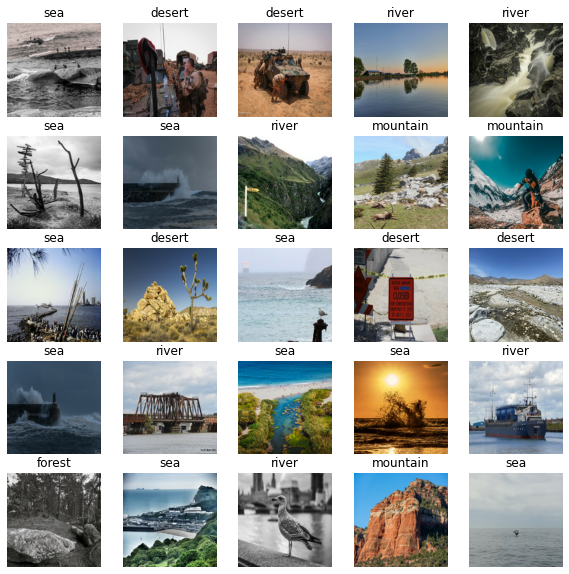

In [11]:
# print some example images
plt.figure(figsize=(10, 10))
for images, labels in full_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Result Discussion

Retrieving the images from a platform where everyone can upload their on images with own tags and descriptions can lead to bad data for our model. <br>
In order to mitigate that risk we introduced randomnes to our fetching function. <br>
With that we want to avoid bad data on one handside on the other we don't want to use mulitple pictures of the same object/landscape uploaded by the same user.

# Data Preparation

In [12]:
# split in training and test set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2873 files belonging to 5 classes.
Using 2299 files for training.
Found 2873 files belonging to 5 classes.
Using 574 files for validation.


In [13]:
# set amount of classes to amount of keywords
num_classes = len(keywords)

## Functions

In [14]:
# function to visualize training results

def visualize_result():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

# Model Creation and Training

Below we will show different iterations of our models <br>
The first model shows our initial setup. The following will show all the modifications that were made during the process

## First training

In [18]:
# define the model
#early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# print summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

Epoch 1/20
72/72 [==============================] - 27s 369ms/step - loss: 2.0621 - accuracy: 0.2859 - val_loss: 1.2804 - val_accuracy: 0.4390
Epoch 2/20
72/72 [==============================] - 29s 404ms/step - loss: 1.1949 - accuracy: 0.5103 - val_loss: 1.2804 - val_accuracy: 0.4913
Epoch 3/20
72/72 [==============================] - 29s 398ms/step - loss: 1.1326 - accuracy: 0.5411 - val_loss: 1.2426 - val_accuracy: 0.5122
Epoch 4/20
72/72 [==============================] - 28s 385ms/step - loss: 1.0782 - accuracy: 0.5753 - val_loss: 1.2834 - val_accuracy: 0.5035
Epoch 5/20
72/72 [==============================] - 26s 363ms/step - loss: 0.9444 - accuracy: 0.6294 - val_loss: 1.3988 - val_accuracy: 0.5052
Epoch 6/20
72/72 [==============================] - 28s 384ms/step - loss: 0.8105 - accuracy: 0.6728 - val_loss: 1.5437 - val_accuracy: 0.4826
Epoch 7/20
72/72 [==============================] - 28s 389ms/step - loss: 0.6018 - accuracy: 0.7831 - val_loss: 1.5358 - val_accuracy: 0.4895

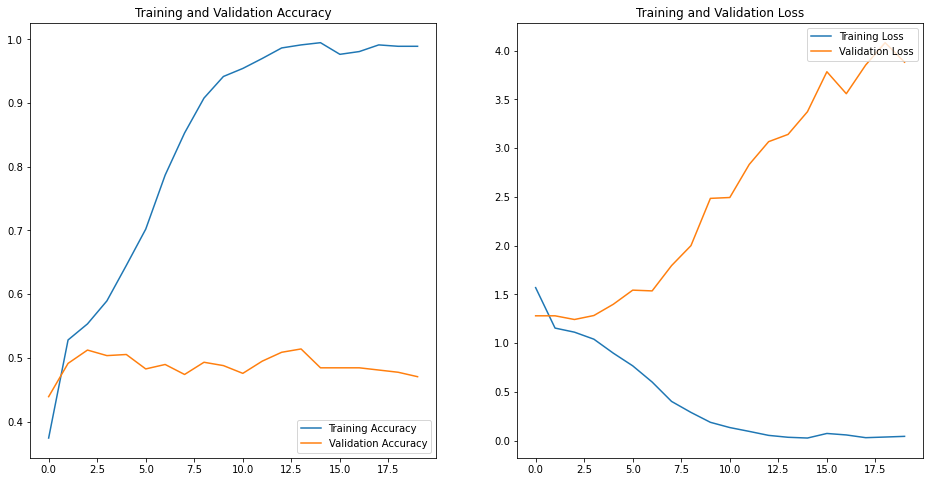

In [19]:
# Train the model
epochs=20
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  #callbacks=[early_stopping_cb]
)

# save the model
model.save('landscape_classifier_v1.h5')

# visualize result
visualize_result()

### Result Discussion

We reached quite a good result on the first try with the training data set. <br>
In accuracy the model performs approx. 20-25% worse with the validation data set. Additionally the difference in loss is extremely high compared to the trainig data set <br>
In order to improve the result for the validation data set we'll introduce **dropout, regularization** and **data augmentation** to the model in the next iteration in order to avoid overfitting.

## Second training

Added dropout and regularization to the model

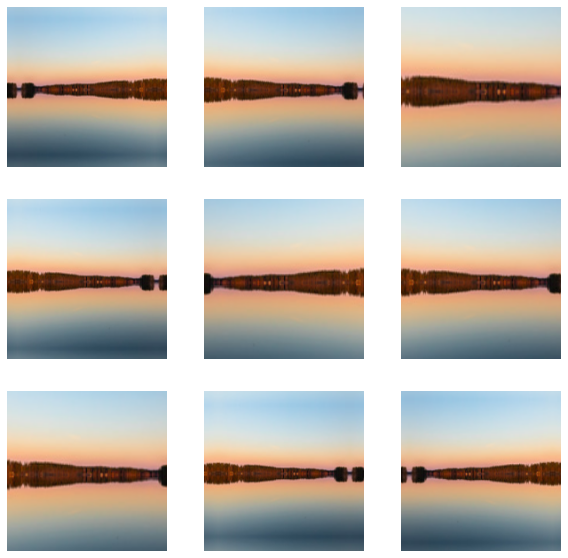

In [20]:
# data augmentation

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomZoom(0.3),
    #layers.experimental.preprocessing.RandomRotation(0.3),
  ]
)

# print an example
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [22]:
# define the model
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
  layers.Dense(num_classes)
])

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# print summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 45, 45, 64)       

Epoch 1/20
72/72 [==============================] - 30s 408ms/step - loss: 2.3965 - accuracy: 0.3035 - val_loss: 1.4435 - val_accuracy: 0.4774
Epoch 2/20
72/72 [==============================] - 29s 400ms/step - loss: 1.4267 - accuracy: 0.4772 - val_loss: 1.4161 - val_accuracy: 0.4634
Epoch 3/20
72/72 [==============================] - 29s 403ms/step - loss: 1.3979 - accuracy: 0.4614 - val_loss: 1.3822 - val_accuracy: 0.4774
Epoch 4/20
72/72 [==============================] - 29s 400ms/step - loss: 1.3210 - accuracy: 0.5193 - val_loss: 1.3827 - val_accuracy: 0.4704
Epoch 5/20
72/72 [==============================] - 29s 400ms/step - loss: 1.3576 - accuracy: 0.4775 - val_loss: 1.4214 - val_accuracy: 0.4756
Epoch 6/20
72/72 [==============================] - 29s 396ms/step - loss: 1.3153 - accuracy: 0.5103 - val_loss: 1.3113 - val_accuracy: 0.5087
Epoch 7/20
72/72 [==============================] - 29s 399ms/step - loss: 1.2844 - accuracy: 0.5131 - val_loss: 1.2977 - val_accuracy: 0.5017

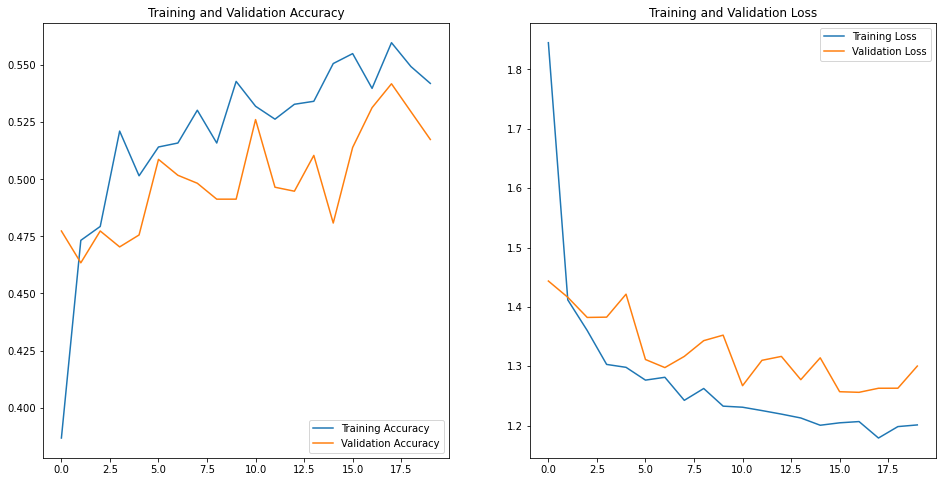

In [23]:
# train the model
epochs=20
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  callbacks=[early_stopping_cb]
)

# save the model
model.save('landscape_classifier_v2.h5')

# visualize result
visualize_result()

### Result Discussion

We were able to reduce the overfitting by introducing dropout and data augmentation. <br>
Instead, we have now a problem with a smaller accuracy. Anyways, we would like to test the performance on "real world" data and compare it with a state of the art model.

## Third Training
Added more layers

In [34]:
# define the model
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
  layers.Dense(num_classes)
])

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# print summary of the model
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 90, 90, 16)        2320      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 45, 45, 16)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 45, 45, 16)       

Epoch 1/20
72/72 [==============================] - 26s 346ms/step - loss: 2.2448 - accuracy: 0.3130 - val_loss: 1.5064 - val_accuracy: 0.3972
Epoch 2/20
72/72 [==============================] - 25s 345ms/step - loss: 1.4494 - accuracy: 0.4182 - val_loss: 1.3897 - val_accuracy: 0.4268
Epoch 3/20
72/72 [==============================] - 25s 347ms/step - loss: 1.3456 - accuracy: 0.4704 - val_loss: 1.3474 - val_accuracy: 0.4477
Epoch 4/20
72/72 [==============================] - 25s 346ms/step - loss: 1.3052 - accuracy: 0.4828 - val_loss: 1.3806 - val_accuracy: 0.4582
Epoch 5/20
72/72 [==============================] - 25s 344ms/step - loss: 1.3463 - accuracy: 0.4718 - val_loss: 1.3222 - val_accuracy: 0.4843
Epoch 6/20
72/72 [==============================] - 25s 345ms/step - loss: 1.3133 - accuracy: 0.4739 - val_loss: 1.2811 - val_accuracy: 0.4808
Epoch 7/20
72/72 [==============================] - 25s 344ms/step - loss: 1.2277 - accuracy: 0.5076 - val_loss: 1.3293 - val_accuracy: 0.4826

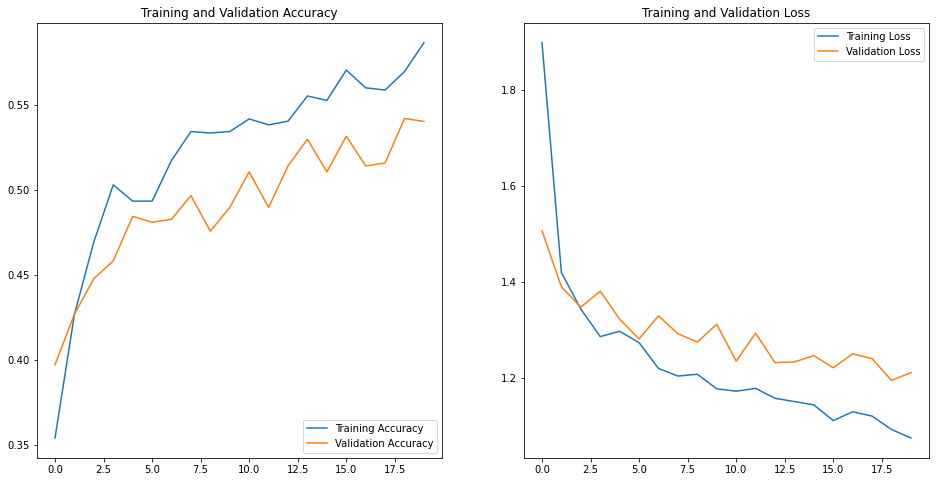

In [35]:
# train the model
epochs=20
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  callbacks=[early_stopping_cb]
)

# save the model
model.save('landscape_classifier_v3.h5')

# visualize result
visualize_result()

## Model testing

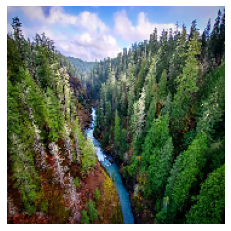

This image most likely belongs to forest with a 71.09 percent confidence.
********************************************


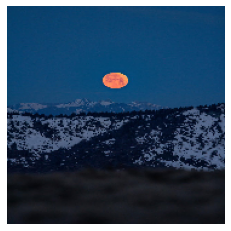

This image most likely belongs to sea with a 36.54 percent confidence.
********************************************


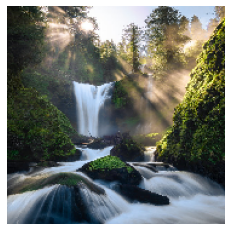

This image most likely belongs to river with a 68.85 percent confidence.
********************************************


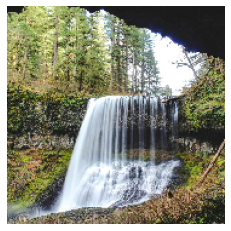

This image most likely belongs to forest with a 87.34 percent confidence.
********************************************


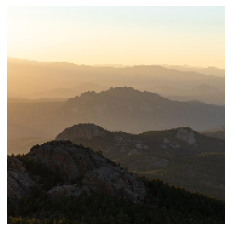

This image most likely belongs to mountain with a 44.34 percent confidence.
********************************************


In [36]:
# load the images
img_amount = 5
i = 1

while i <= img_amount:
    try:
        images_path = f'https://github.com/amkobee/ADS/raw/main/scraped_images/test_{i}.png'
        test_image_path = tf.keras.utils.get_file(f'test_{i}.png', origin=images_path)
    except:
        break

    img = keras.preprocessing.image.load_img(
        test_image_path, target_size=(img_height, img_width)
    )

    # print the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # make a prediction
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    print('********************************************')

    i+=1


## Comparison with ResNet V2 50

In [42]:
model_name = "resnet_v2_50" # @param ['bit_s-r50x1', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'inception_v3', 'inception_resnet_v2', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152']

model_handle_map = {
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature_vector/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4",  
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature_vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
}

model_image_size_map = {
  "efficientnet_b0": 224,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 180)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 32 #@param {type:"integer"}

Selected model: resnet_v2_50 : https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4
Input size (180, 180)


In [43]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, validation_split=.20, horizontal_flip=True, zoom_range=0.5)# add data augmentation trasnformations
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, validation_split=.20)#no data augmentation in the validation set

train_generator = train_datagen.flow_from_directory(
    '/content/content/photos/', subset="training", shuffle=True,target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_generator = valid_datagen.flow_from_directory(
    '/content/content/photos/', subset="validation", shuffle=False, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

Found 2300 images belonging to 5 classes.
Found 573 images belonging to 5 classes.


In [44]:
feature_extractor_layer = hub.KerasLayer(model_handle, trainable=False)

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for /var/folders/1w/dw3d3_5n63zdggx9p94m35000000gn/T/tfhub_modules/bac7ac3188f04e16775f615fb36c0a31f51c4d06/variables/variables
 If trying to load on a different device from the computational device, consider using setting the `experimental_io_device` option on tf.saved_model.LoadOptions to the io_device such as '/job:localhost'.

In [ ]:
model = tf.keras.Sequential([

    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    feature_extractor_layer,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 10245     
Total params: 23,575,045
Trainable params: 10,245
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
model.compile(
  optimizer='adam', 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=10, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/10
125/125 [==============================] - 39s 275ms/step - loss: 1.6045 - accuracy: 0.4210 - val_loss: 1.4029 - val_accuracy: 0.5131
Epoch 2/10
125/125 [==============================] - 34s 272ms/step - loss: 1.3314 - accuracy: 0.5408 - val_loss: 1.4057 - val_accuracy: 0.5121
Epoch 3/10
125/125 [==============================] - 34s 272ms/step - loss: 1.2724 - accuracy: 0.5692 - val_loss: 1.3909 - val_accuracy: 0.5343
Epoch 4/10
125/125 [==============================] - 34s 271ms/step - loss: 1.2328 - accuracy: 0.5780 - val_loss: 1.3713 - val_accuracy: 0.5302
Epoch 5/10
125/125 [==============================] - 34s 273ms/step - loss: 1.2091 - accuracy: 0.5840 - val_loss: 1.3517 - val_accuracy: 0.5625
Epoch 6/10
125/125 [==============================] - 34s 271ms/step - loss: 1.1781 - accuracy: 0.6058 - val_loss: 1.3523 - val_accuracy: 0.5524
Epoch 7/10
125/125 [==============================] - 34s 273ms/step - loss: 1.1705 - accuracy: 0.6072 - val_loss: 1.3481 - val_ac

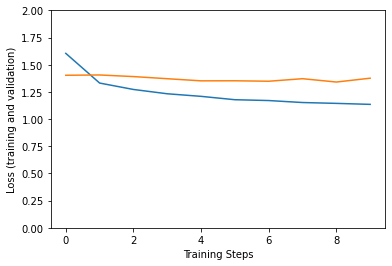

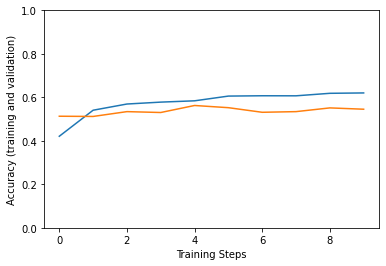

In [ ]:
# Visualizing training results

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

### Result Discussion
The ResNet V2 50 model outperforms our model by approx. 10-15% in accuracy. Also, the training and validation are much closer to each other than in our model<br>
Still, our model uses almost 10 times less layers.


